In [1]:
!nvidia-smi

Wed Sep 25 05:12:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    77W / 300W |  16034MiB / 16130MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   51C    P0    73W / 300W |  11380MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import sys
package_path = 'EfficientNet-PyTorch/'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet
from radam import RAdam, PlainRAdam, AdamW
from am_softmax import AMSoftmaxLoss, AngleSimpleLinear

In [4]:
import os
import gc
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import pretrainedmodels

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

import warnings
warnings.filterwarnings('ignore')

## Config

In [5]:
config = {
    'SEED': 42,
    'CLASSES': 1108,
    'PATH_DATA': '/home/tienen/kaggle_dataset_drugs/',
    'PATH_WEIGHTS': '/home/jupyter/Nikita/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 32,
    'VAL_SIZE': 0.05,
    'MODEL_NAME': 'SeResNext',
    'USE_ANGULAR': True,
    'USE_BN': False,
    'LR': 1e-4,
    'LR_STR': '1e-4',
    'TURN_OFF_ON_N_EPOCHS': 0,
}

In [6]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(config['SEED'])

In [7]:
#lazy calculation of stats
pixel_stats = pd.read_csv(config['PATH_DATA']+'pixel_stats.csv')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


In [8]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

## Data

In [9]:
df = pd.read_csv(config['PATH_DATA']+'/train.csv')
df_test = pd.read_csv(config['PATH_DATA']+'/test.csv')

df['category'] = df['experiment'].apply(lambda x: x.split('-')[0])
df_test['category'] = df_test['experiment'].apply(lambda x: x.split('-')[0])

In [10]:
def generate_df(train_df, site):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(site) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df

train_df_site1 = generate_df(df, site=1)
train_df_site2 = generate_df(df, site=2)
proc_train_df = train_df_site1.append(train_df_site2)

In [11]:
proc_train_df.head(2)

,path,sirna
0,HEPG2-01/Plate1/B03_s1_w,513
1,HEPG2-01/Plate1/B04_s1_w,840


In [12]:
il = MultiChannelImageList.from_df(df=proc_train_df, path=config['PATH_DATA']+'train/')

def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np
# il[0]

In [13]:
data = (MultiChannelImageList.from_df(df=proc_train_df, path=config['PATH_DATA']+'train/')
        .split_by_rand_pct(config['VAL_SIZE'])
        .label_from_df()
        .transform(get_transforms(do_flip=False), size=512)
        .databunch(bs=config['BATCH_SIZE'], num_workers=64)
        .normalize(stats)
       )

# data.show_batch()

## Model

In [14]:
def seresnext(num_classes=1000, num_channels=6, pretrained=True, use_bn=True, use_angular=False):
    if pretrained:
        preloaded = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained='imagenet')
    else:
        preloaded = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained=None)
    #print(preloaded)
    
    if use_bn:
        preloaded = nn.Sequential(OrderedDict([
                        ('norm0', nn.BatchNorm2d(6)),
                        ('model', preloaded)
        ]))
        model = preloaded.model
    else:
        model = preloaded
    
    trained_kernel = model.layer0.conv1.weight
    new_conv = nn.Sequential(nn.Conv2d(num_channels, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False))
    with torch.no_grad():
        new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
    model.layer0.conv1 = new_conv
    
    if use_angular:
        fc_input_features = model.last_linear.in_features
        model.last_linear = AngleSimpleLinear(fc_input_features*100, num_classes)
    else:
        fc_input_features = model.last_linear.in_features
        model.last_linear = nn.Linear(fc_input_features, num_classes, bias=True)
    
    return preloaded

In [15]:
model = seresnext(num_classes=config['CLASSES'], pretrained=False, use_bn=config['USE_BN'], use_angular=config['USE_ANGULAR'])
model.to(config['DEVICE']);

## Learner

In [16]:
criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

learn = Learner(data=data,
                model=model,
                opt_func=RAdam,
                loss_func=criterion,
                metrics=[fastai.metrics.accuracy],
                callback_fns=ShowGraph) # .to_fp16()

learn.model = nn.DataParallel(learn.model)
learn.path = Path(config['MODEL_NAME'])
checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME'],
                                        every='epoch', monitor='valid_loss')

--- 

epoch,train_loss,valid_loss,accuracy,time
0,21.730875,21.680407,0.005478,49:00
1,21.006649,21.118532,0.023281,49:20
2,20.194250,20.343077,0.068748,50:08
3,19.551008,19.648382,0.125445,49:57
4,18.809809,18.934727,0.206245,49:42
5,18.192541,18.869965,0.193919,49:53
6,17.512810,19.112432,0.167899,49:49
7,16.940035,18.039856,0.259107,50:06
8,16.181509,17.176718,0.314708,50:24
9,15.178504,16.458693,0.362366,50:15


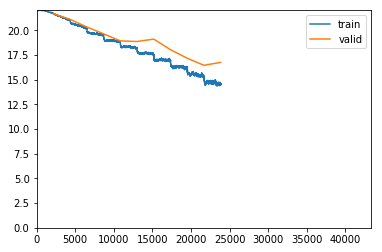

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    20,
    max_lr=config['LR'],
    wd=1e-4,
    callbacks=[checkpoint_callback],
)

---

In [16]:
criterion = AMSoftmaxLoss(margin_type='cos', gamma=2., m=0.5, s=30, t=1.)

learn = Learner(data=data,
                model=model,
                opt_func=RAdam,
                loss_func=criterion,
                metrics=[fastai.metrics.accuracy],
                callback_fns=ShowGraph) # .to_fp16()
learn.model = nn.DataParallel(learn.model)
learn.path = Path(config['MODEL_NAME'])

best_epoch = 10
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))

checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME'],
                                        every='epoch', monitor='valid_loss')

Loaded SeResNext_10


epoch,train_loss,valid_loss,accuracy,time
11,13.714311,15.257472,0.397425,48:15
12,12.841400,16.008236,0.357162,48:02
13,12.319409,14.830042,0.408929,48:26
14,11.577343,14.373359,0.442618,48:30
15,10.903573,13.500648,0.476582,48:26
16,10.300396,14.082786,0.446179,48:18
17,9.873484,13.982022,0.453300,48:30
18,9.684184,14.452735,0.434949,48:40
19,9.451108,13.633254,0.471378,48:41


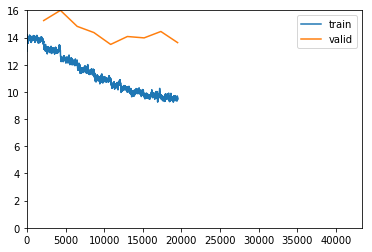

In [17]:
learn.unfreeze()
learn.fit_one_cycle(
    20,
    max_lr=config['LR'],
    wd=1e-4,
    callbacks=[checkpoint_callback],
    start_epoch=11,
)

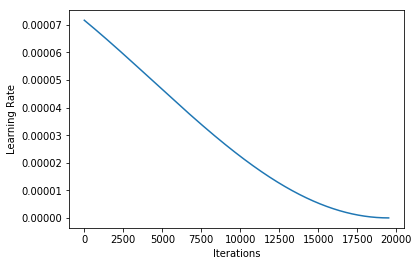

In [18]:
learn.recorder.plot_lr()

## Inference

In [57]:
best_epoch = 13
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch));

In [58]:
test_df_site1 = generate_df(df_test, site=1)
data_test = MultiChannelImageList.from_df(df=test_df_site1, path=config['PATH_DATA']+'test/')
learn.data.add_test(data_test)

preds_site1, _ = learn.get_preds(DatasetType.Test)

test_df_site2 = generate_df(df_test, site=2)
data_test = MultiChannelImageList.from_df(df=test_df_site2, path=config['PATH_DATA']+'test/')
learn.data.add_test(data_test)

preds_site2, _ = learn.get_preds(DatasetType.Test)

In [59]:
predictions = 0.5*(preds_site1.numpy() + preds_site2.numpy())

In [60]:
df_test['sirna'] = np.argmax(predictions, axis=1).astype(int)
submission = df_test.copy()
submission.to_csv('submits/{}_{}epoch_lr{}.csv'.format(config['MODEL_NAME'], best_epoch, config['LR_STR']),
                  index=False, columns=['id_code','sirna'])

In [61]:
submission.head()

,id_code,experiment,plate,well,category,path,sirna
0,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2,HEPG2-08/Plate1/B03_s2_w,855
1,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2,HEPG2-08/Plate1/B04_s2_w,637
2,HEPG2-08_1_B05,HEPG2-08,1,B05,HEPG2,HEPG2-08/Plate1/B05_s2_w,506
3,HEPG2-08_1_B06,HEPG2-08,1,B06,HEPG2,HEPG2-08/Plate1/B06_s2_w,894
4,HEPG2-08_1_B07,HEPG2-08,1,B07,HEPG2,HEPG2-08/Plate1/B07_s2_w,711


## Plates Leak

In [62]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = df.loc[df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    
print(plate_groups[:10,:])

[[4 2 3 1]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [3 1 2 4]
 [1 3 4 2]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [4 2 3 1]]


In [63]:
all_test_exp = df_test.experiment.unique()

group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = df_test.loc[df_test.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = df_test.loc[df_test.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

In [64]:
exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 0 3]


In [65]:
# this is the function that sets 75% of the sirnas to zero according to the selected assignment

def select_plate_group(pp_mult, idx):
    sub_test = df_test.loc[df_test.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

In [66]:
sub = submission.copy()

for idx in range(len(all_test_exp)):
    indices = (df_test.experiment == all_test_exp[idx])
    preds_2 = predictions[indices, :].copy()
    
    preds_2 = select_plate_group(preds_2, idx)
    sub.loc[indices,'sirna'] = preds_2.argmax(1)

In [67]:
(sub.sirna == submission.sirna).mean()

0.5419912549630598

In [68]:
sub.to_csv('submits/{}_{}epochs_lr{}_plates_leak.csv'.format(config['MODEL_NAME'], best_epoch, config['LR_STR']),
           index=False, columns=['id_code','sirna'])

In [69]:
len(submission.sirna.unique()), len(sub.sirna.unique())

(1054, 1097)

In [70]:
sub.head()

,id_code,experiment,plate,well,category,path,sirna
0,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2,HEPG2-08/Plate1/B03_s2_w,855
1,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2,HEPG2-08/Plate1/B04_s2_w,332
2,HEPG2-08_1_B05,HEPG2-08,1,B05,HEPG2,HEPG2-08/Plate1/B05_s2_w,836
3,HEPG2-08_1_B06,HEPG2-08,1,B06,HEPG2,HEPG2-08/Plate1/B06_s2_w,609
4,HEPG2-08_1_B07,HEPG2-08,1,B07,HEPG2,HEPG2-08/Plate1/B07_s2_w,711
